# AE4350 - Bio-inspired Intelligence and Learning Assignment
This is the Main notebook for training and testing the DRL portfolio management system
<br>Created on Thu May 12 13:22:50 2022
<br>@author: Reinier Vos, 4663160-TUD

In [1]:
SCRIPT_VERSION = 17
try:
    from utility_v17 import Agent, UtilFuncs, Statistics
except:
    pass
try:
    from AE4350_Assignment.utility_v17 import Agent, UtilFuncs, Statistics
except:
    pass
import sys
from tqdm import tqdm
from tqdm.notebook import trange
import os
import numpy as np
import pandas as pd
import json
import plotly.graph_objects as go
#In TensorFlow 2.3+, you can disable eager mode anytime using the following method:
import tensorflow as tf
#tf.autograph.set_verbosity(0)
import plotly.graph_objects as pgo
import time
#tf.config.run_functions_eagerly(True)
#tf.config.run_functions_eagerly(False)

import logging
#logging.getLogger("tensorflow").setLevel(logging.ERROR)

SEED = 10
np.random.seed(SEED)
tf.random.set_seed(SEED)
import matplotlib.pyplot as plt
import re

print(tf.__version__)
tf.config.list_physical_devices('GPU')

print("\nATTENTION RUNNNING SCRIPT VERSION = {}\n".format(SCRIPT_VERSION))

2.8.0

ATTENTION RUNNNING SCRIPT VERSION = 17



In [ ]:
### Model summaries
from utility_v16 import Actor, Critic
window_size = 128

convLayers = [[64,4],[64,8],[128,8]]
convLayers = [[64,3]]
convLayers = []
convLayers = [[64,3],[64,3],[128,3],[128,3]]
modelsHyper_dct = {"actor_ts_convLayers":convLayers, # [filter,kernelsize]
                   "actor_ts_maxPoolsize":2, # = 0 means not used
                   "actor_ts_maxPoolstrides":2, # default 1
                   "actor_ts_dLayers":[256,256,128,64], # agent.LAST layer will be concatted 
                   "actor_util_dLayers":[], #[16,8], # agent.LAST layer will be concatted 
                   "actor_comb_dLayers":[], #[128,64,32],
                   "actor_regularizer":1e-14, # currently only applied to dense layers
                   "critic_ts_convLayers":convLayers, # [filter,kernelsize]
                   "critic_ts_maxPoolsize":0, # = 0 means not used
                   "critic_ts_maxPoolstrides":2, # default 1
                   "critic_ts_dLayers":[256,256,128,64], # agent.LAST layer will be concatted 
                   "critic_util_dLayers":[],#[16,8], # agent.LAST layer will be concatted 
                   "critic_comb_dLayers":[], #[128,64,32],
                   "critic_action_dLayers":[],#[16,8], # action probabilities related layer
                   "critic_final_dLayers":[32,16], # layers after states and action added 
                   "critic_regularizer":1e-14, # currently only applied to dense layers
                   "use_batchNorm_tsconv":False,
                   "use_batchNorm_tsdense":True,
                   "use_dropout_tsdense":True,
                   "ts_dropoutProb":0.2,
}

actor = Actor(window_size,6,3,modelsHyper_dct)
actor.model.summary()
critic = Critic(window_size,6,3,modelsHyper_dct)
critic.model.summary()

### README
<br> Ensure utility v17 is used!
<br> This version has is the google colab compatible version, change next cell for desired environment

In [2]:
# github link

using_colab = False
pay = False # whether youre using the payed version (i.e. own server)

if using_colab:
    from google.colab import files
    if not pay:
        from google.colab import drive
        import shutil
        drive.mount('/content/drive', force_remount=True)
    !git clone https://github.com/rwvosTUD/AE4350_Assignment.git

Models will be saved to C:\Users\Reinier Vos\Documents\YEAR2021_2022\AE MSc C&S\AE4350-Bio_inspiredIntelligenceAndLearning\assignment\scripts\runs/TESTST
Reward function description: EXPERIMENTAL; ONLY USE FOR N = 1


C:\Users\Reinier Vos\anaconda3\envs\tf280\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Succesfully saved model parameters to folder runs/TESTST
=== ATTENTION: running model for 1 stocks ===
1005


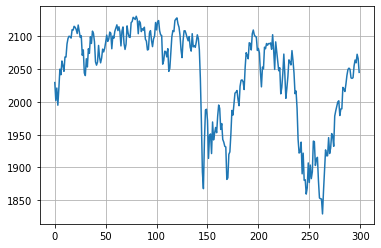

In [3]:
checkpoint_dir = "runs/TESTST"#"runs/v15/v16_r9_p1" #v10_reg9_p1" # "colabv11_w"

#convLayers = [[32,8],[32,8],[64,4],[64,4],[128,4],[128,4]]
#convLayers = [[32,5],[32,5],[64,5],[64,5]]
#convLayers = [[64,3],[64,3],[128,3],[128,3]]
#convLayers = [[64,4], [64, 4], [128, 4], [128, 4]]
#convLayers = [[64,16], [64, 16], [128, 32], [128, 32]]
convLayers = []
'''
ts_dlayers = [256,256,256,128,64] #[256,256,128,64]
comb_layers = [128,128,64,64,32] #[128,64,64,32]
critic_final_dLayers = [128,128,64,64,32] #[128,128,64,32]
#'''
ts_dlayers = [256,256,256,128,128] #bigger
comb_layers = [256, 128, 128, 64, 32] #[128,64,64,32]
critic_final_dLayers = [256, 128, 128, 64, 32] #[128,128,64,32]
#'''
modelsHyper_dct = {"actor_ts_convLayers":convLayers, # [filter,kernelsize]
                   "actor_ts_maxPoolsize":0, # = 0 means not used
                   "actor_ts_maxPoolstrides":2, # default 1
                   "actor_ts_dLayers":ts_dlayers, # agent.LAST layer will be concatted 
                   "actor_util_dLayers":[], #[16,8], # agent.LAST layer will be concatted 
                   "actor_comb_dLayers":comb_layers,
                   "actor_regularizer":1e-14, # currently only applied to dense layers
                   "critic_ts_convLayers":convLayers, # [filter,kernelsize]
                   "critic_ts_maxPoolsize":0, # = 0 means not used
                   "critic_ts_maxPoolstrides":2, # default 1
                   "critic_ts_dLayers":ts_dlayers, # agent.LAST layer will be concatted 
                   "critic_util_dLayers":[],#[16,8], # agent.LAST layer will be concatted 
                   "critic_comb_dLayers":comb_layers,
                   "critic_action_dLayers":[],#[16,8], # action probabilities related layer
                   "critic_final_dLayers":critic_final_dLayers, # layers after states and action added 
                   "critic_regularizer":1e-14, # currently only applied to dense layers
                   "use_batchNorm_tsconv":False,
                   "use_batchNorm_tsdense":True,
                   "use_dropout_tsdense":True,
                   "ts_dropoutProb":0.2,
}

agent_dct = {"stateTS_size":64,#128, # i.e. window_size 
             "stateUT_size":6, 
             "batch_size":128,
             "data_extraWindow":1,
             "n_budget":1,
             "is_terminal_threshold":1000,
             "model_hyper": modelsHyper_dct,
             "tanh_scale":80, #80
             "gamma":0.99,
             "tau":0.001,
             "episode_window": 300,
             "mask_input":False,
}

reward_dct = {"rewardType":7, # NOTICE WHICH REWARD FUNCTION WE USE
              "penalty":0,
              "hold_scale": 17,#90, #40,
              "trade_scale":14,
              "trade_cost":0,
              "max_holds":100, # minimum hardcoded to 100!
              "prob_power":1, 
}
extra_dct = {"EXTRACASH" : reward_dct["trade_cost"], # 100
            "EXPAND" : 5,
            "LAST" : 5,
            "PROFITDIFF" : 200,
            "EXPAND_TIMER":  10,
            "TRADECOST_ACTUAL" : 3,
             "START_OFFSET" : 300, #700
             "VALI_EC":50, # extracash amount for validation
             "SCRIPT_VERSION":SCRIPT_VERSION,
             "SEED":SEED,
}

data, data_extra = UtilFuncs.get_data("traindata",agent_dct["data_extraWindow"],
                                      SCRIPT_VERSION, colab = using_colab,)
l = len(data) - 1

window_size = agent_dct["stateTS_size"]
data_extraWindow =  agent_dct["data_extraWindow"]
agent = Agent(agent_dct, data[window_size],
              checkpoint_dir, reward_dct, extra_dct) 
stats = Statistics(checkpoint_dir, training = True)
stats_val = Statistics(checkpoint_dir, training = False)
print("=== ATTENTION: running model for {} stocks ===".format(agent_dct["n_budget"]))
print(l)
plt.plot(data[window_size+agent.START_OFFSET:(agent.START_OFFSET+window_size+agent.episode_window)])
plt.grid(True)

 ## Loading of models
### General loading

In [ ]:
### loading of model
#load_dir = "runs/run3"
#agent.load_models(load_dir,40)
#load_dir = "runs/version3/run6_r5"
if using_colab:
    load_dir = "AE4350_Assignment/prev_runs"
else:
    load_dir = "runs/colab/content/v15_NomaskA2_p2" 
    
load_episode = 1500
#buffer_episode_size = agent_dct["episode_window"]
#agent.load_models(load_dir,load_episode,buffer_episode_size, buffer = True)
agent.load_models(load_dir,load_episode, buffer = True, using_colab = using_colab)
#agent.memory.memory_counter = load_episode*2000

### Validation data loading & plotting

In [ ]:
growth_buyhold = UtilFuncs.plot_data(agent, data, data_extra, data_extraWindow, window_size, training = True)
data_val, data_extra_val = UtilFuncs.get_data("validationdata", data_extraWindow, SCRIPT_VERSION,  colab = using_colab)
l_val = len(data_val)-1
growth_buyhold_val = UtilFuncs.plot_data(agent, data_val, data_extra_val, data_extraWindow, window_size, training = False)

# Main training & validation loop

In [ ]:
#from utility_v12 import UtilFuncs
show_figs = False
debug = False

testing = False
#''' # uncomment this when resetting a trial 
reward_lst = []
profitdiff_lst = []
expansions_lst = []
expand_i = 1

history = {}
history["training_profit"] = []
history["training_pratio"]  = []
history["validation_profit"] = []
history["validation_pratio"] = []
history["validation_extraCash"] = []
#'''
deadlock_on = False
timer = 0 
expansion_size = 1 # start expansion_size at 1, will be set to EXPANSION after first

saveIter = 30
start = 0
episode_count = 10000 #300


use_terminateFunc = True
terminateFunc_on = False
#'''
deadlock_probStart = 1/10 #1/6  # exploratory probability hack for actions 1 & 2
decay = 0.90
decay_op = 2-decay
deadlock_prob = deadlock_probStart*(decay**(start)) # if we start later in an epoch
switch_episode = 50
#'''
#extra_explore = False # whether to override the original exploration sheme
#scaling = 0.1 #0.02
tbzip_folder="/content/{0}_z.zip".format(checkpoint_dir)
zip_folder = "/content/{0}".format(checkpoint_dir)

min_t = window_size 
stats.reset_all(agent.n_budget*data[window_size], growth_buyhold)
stats_val.reset_all(agent.n_budget*data_val[window_size], growth_buyhold_val)
print("\n ATTENTION DEADLOCK IS SET TO {0} \n".format(deadlock_on))
prev_terminate = True
for e in range(start,episode_count):
    agent.is_eval = False # training!
    
    if e % saveIter == 0 and e != 0:
        episode_start = window_size
        episode_end = l
        agent.is_eval = True # training!
    else:
        ''' 
        SHUFFLING START 
        ''' 
        
        
        #deadlock_go = False
        if (e-start) > agent.LAST:
            profitdiff_mean = np.mean(profitdiff_lst[-agent.LAST:])

            if profitdiff_mean <= 0:
                # EXPONENTIALLY GROW
                deadlock_prob = min(deadlock_prob*decay_op,deadlock_probStart) 
                timer = 0 # reset
            elif profitdiff_mean > agent.PROFITDIFF:
                # DECAY
                deadlock_prob = max(deadlock_prob*decay,0.0001) 
                timer += 1
            else: 
                timer = 0  # reset 
                
            print("E{0} - Deadlock probability {1} | Timer = {2} | expansions = {3} | Prev mean = {4}".format(e,
                                                                         round(deadlock_prob,3), 
                                                                         timer,
                                                                         expand_i-1,
                                                                         profitdiff_mean))
            if timer >= agent.EXPAND_TIMER: 
                expand_i += 1 
                timer = 0
                expansion_size = agent.EXPAND
                #deadlock_go = True

        
        utils_start = [l,agent.START_OFFSET, agent.episode_window]
        episode_start  = UtilFuncs.get_episodeStart(agent, expand_i, expansion_size, utils_start)
        episode_end = episode_start+agent.episode_window
        print("E{2} - Current window [{0},{1}]".format(episode_start,episode_end,e))
    
    '''
    DEADLOCK SWITCH OFF
    
    '''
    if e == 30:
        deadlock_on = False 
        print("\n ATTENTION DEADLOCK IS SET TO {0} \n".format(deadlock_on))
    
    
    #if e >= switch_episode:
    pbar = tqdm(total=(episode_end-episode_start), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ') # progress bar
    #print("== Episode " + str(e) + "/" + str(episode_count) +" ==")
    
    agent.reset(data[episode_start])
    agent.balance += agent.EXTRACASH
    stats.reset_episode()
    stats.extraCash += agent.EXTRACASH 
    '''
    extra cash!
    '''
    
    
    sold_price = 0
    bought_price = agent.inventory_value
    utils_state = [episode_end, stats.n_holds,stats.n_trades, agent.trade_cost]
    state = UtilFuncs.get_state(agent, data, episode_start, window_size + 1, utils_state)
    
    done = False
    terminate = False
    
    #REWARD TYPE SWITCH EXPERIMENT
    #agent.switch_rewardType(7,switch_episode,e)
    '''
    if not e == start: # not prev_terminate and not e == start:
        if deadlock_on:
            deadlock_prob = deadlock_prob*decay # remove
            print("E{0} - Deadlock probability {1}".format(e,prob))
    '''
    # =============================== ITERATION ======================================================
    for t in range(episode_start,episode_end):

        utils_act = []
        action, action_prob = agent.act(state, utils_act)
        
        # DEADLOCK EXPERIMENT
        action = UtilFuncs.break_deadlock(agent,action,e,utils_act, on = deadlock_on) 
            
        # Hanle action
        flags = [use_terminateFunc, terminateFunc_on]
        utils_hdlAct = [action_prob]
        action, profit,  impossible, terminate, term_msg = UtilFuncs.handle_action(agent, stats, action, data, 
                                                                                   t, flags, utils_hdlAct, training = True)
        
        # terminate if required
        if terminate or t == episode_end-1:
            # terminating i.e. agent.LAST iteration 
            done = True # terminal state has no 'next' so change done variable before use in next lines
            
        # get reward
        if t < data_extraWindow:
            ptn = data_extra[t]
        else: 
            ptn = data[t-data_extraWindow]
        utils_reward = [data[t],data[t-1], data[t+1], action, action_prob[0], stats.n_trades, stats.n_holds, impossible, l, terminate]
        reward = agent.get_reward(agent, profit, utils_reward, done)
        stats.total_reward += reward
        
        # take step
        utils_state = [episode_end, stats.n_holds,stats.n_trades, agent.trade_cost]
        next_state = UtilFuncs.get_state(agent, data, t + 1, window_size + 1, utils_state)
        if e % saveIter != 0 or e == 0: 
            '''
            SMALL WINDOW EXPERIMENT
            '''
            actor_local_loss = agent.step(action_prob, reward, next_state, done)
        state = next_state
        
        if terminate:
            # ensure consistent length of arrays then terminate trial
            if t >= min_t:
                utils_pad = [l,t]
                stats.pad_on_terminate(utils_pad)    
            print("Episode {0} was terminated at {1}/{2} due to {3}".format(e,t-window_size,episode_end-episode_start, term_msg))
            break
            
        # collect 
        utils_saveIter = [profit, reward, actor_local_loss, action, t-episode_start]
        stats.collect_iteration(agent,utils_saveIter)
        
        pbar.set_description("Episode {0}| Portfolio: {1}| Balance: {2}| Inventory: {3}| RewardAcc: {4}".format(int(e),
                                                                                                                UtilFuncs.to_currency(agent.balance+agent.inventory_value),
                                                                                                                UtilFuncs.to_currency(agent.balance),
                                                                                                                UtilFuncs.to_currency(agent.inventory_value),
                                                                                                                UtilFuncs.to_currency(stats.total_reward)))
        pbar.update()
        
    # ============================ END ITERATION =================================================
    print("E{3} - Amount of +trades {0}, all trades {1} | ratio = {2}".format(stats.n_posiProfits, 
                                                                              stats.n_trades, 
                                                                              round(stats.n_posiProfits/max(1,stats.n_trades),3), 
                                                                              e))
    '''
    SMALL WINDOW EXPERIMENT

    BREAK CURRENT EPISODE, WE WONT SAVE ANYWAY
    '''
    profitBuyhold = data[episode_end-1]-data[episode_start]
    #profitRL = agent.balance+agent.inventory_value-data[episode_start]-agent.trade_cost*stats.n_trades-stats.extraCash
    profitRL = agent.balance+agent.inventory_value-data[episode_start]-agent.TRADECOST_ACTUAL*stats.n_trades-stats.extraCash
    profitdiff = profitRL-profitBuyhold
    print("E{3} - RL profit = {0} | Buyhold = {1} | diff = {2} | tradecost = {4}".format(round(profitRL,2),
                                                                round(profitBuyhold,2),
                                                                round(profitdiff,2),
                                                                e,
                                                                #agent.trade_cost*stats.n_trades,
                                                                agent.TRADECOST_ACTUAL*stats.n_trades,
                                                                ))
    print("E{0} - impossibles {1}/{2} = {3}".format(e, stats.n_impossible,
                                             stats.n_1or2,
                                             round(stats.n_impossible/stats.n_1or2,3)))
    reward_lst.append(stats.total_reward)
    profitdiff_lst.append(profitdiff) 
    expansions_lst.append(expand_i)
    '''
    if e % 25 == 0 and e != 0:
        x = np.arange(start,e+1)
        y = np.array(reward_lst)
        coef = np.polyfit(x,y,1)
        plt.plot(x,y)
        plt.plot(x,x*coef[0]+coef[1])
        plt.plot(x,np.zeros((e-start+1)))
    '''
    if max(e-1,0) % saveIter == 0 and e != 0 and e != 1 and not debug:
        if not prev_terminate:
            # we skip one iteration as we assume the zip file creation is done now
            if using_colab and not pay: 
                #!zip -r /content/run1_colab_r3v2.zip /content/run1_colab
                #files.download(tbzip_folder)
                shutil.copy(tbzip_folder, "/content/drive/MyDrive")
                #b = 1
                #print("Attempting download, system sleep initiated")
                #time.sleep(24) # Sleep system for x seconds, to give time for download
                #print("System sleep terminated, continueing...")
                
    if e % saveIter != 0 or e == 0: 
        continue
        

    
    if True: #not terminate:
        stats.collect_episode(agent,e, [])
        history["training_profit"].append(stats.compete[-1])
        history["training_pratio"].append(stats.n_posiProfits/max(1,stats.n_trades))
        
    if e % saveIter == 0 and e != 0: #and not terminate:
        if not debug:
            # plot and save
            agent.save_models(e)
            utils_fig = [l, window_size]
            stats.plot_figure(data, e, utils_fig, show_figs = show_figs)
            stats.save_statistics(e)
            extraHistory = {}
            extraHistory["reward_lst"] = reward_lst
            extraHistory["profitdiff_lst"] = profitdiff_lst
            extraHistory["expansions_lst"] = expansions_lst 

            with open(f'./{checkpoint_dir}/EXTRAhistory.json', 'w') as fp:
                json.dump(extraHistory, fp)
    
            # ================ VALIDATION LOOP ===============================
            stats_val.reset_episode()
            stats_val.extraCash += agent.VALI_EC
            agent.is_eval = True
            agent.reset(data_val[window_size])
            agent.balance += agent.VALI_EC
            for t in trange(window_size,l_val):
                utils_state = [l_val, stats_val.n_holds,stats_val.n_trades, agent.trade_cost]
                state = UtilFuncs.get_state(agent, data_val, t, window_size + 1, utils_state)
                utils_act = [deadlock_prob,data_val[t]]
                action, action_prob = agent.act(state, utils_act)

                flags = [use_terminateFunc, terminateFunc_on]
                utils_hdlAct = [action_prob]
                action, profit,  impossible, _, _ = UtilFuncs.handle_action(agent, stats_val, action, data_val, 
                                                                                           t, flags, utils_hdlAct, training = True)
                utils_saveIter = [profit, 0., 0., action, t-window_size]
                stats_val.collect_iteration(agent,utils_saveIter)

            stats_val.collect_episode(agent, e, [])
            print("Final validation profit = {0} | extra cash = {1} | +/all trades= {2}/{3}".format(round(stats_val.compete[-1],2),
                                                                            round(stats_val.extraCash,2),
                                                                              stats_val.n_posiProfits,
                                                                               stats_val.n_trades,))
            utils_fig = [l_val, window_size]
            stats_val.plot_figure(data_val, e, utils_fig, show_figs = show_figs)
            history["validation_profit"].append(stats_val.compete[-1])
            history["validation_pratio"].append(stats_val.n_posiProfits/max(1,stats_val.n_trades))
            history["validation_extraCash"].append(stats_val.extraCash)
            # ============= END VALIDATION LOOP =============================
            with open(f'./{checkpoint_dir}/e{e}/history.json', 'w') as fp:
                json.dump(history, fp)
            
            
        if using_colab and not debug:
            !zip -r "$tbzip_folder" "$zip_folder"
            print("Zip file created, saved next run")
        

    '''
    EXPERIMENT
    '''
    if terminate:
        prev_terminate = True
    else:
        prev_terminate = False
            
    #if debug and not terminate:
    #    print("E{3} - Amount of impossibles {0} out of trades {1}, ratio = {2}".format(n_impossible, n_1or2, n_impossible/n_1or2, e))

    

# Additional validation procedures

In [4]:
load_dir =  "runs/v17/content/v17_bigM"
#load_dir =  "runs/v17/content/v17_vanilla"
#load_dir =  "runs/v17/content/v17_w80"
files = os.listdir(load_dir)
files = [list(map(int, re.findall('\d+', file))) for file in files]
files.sort()
files = files[5:] # skip first five

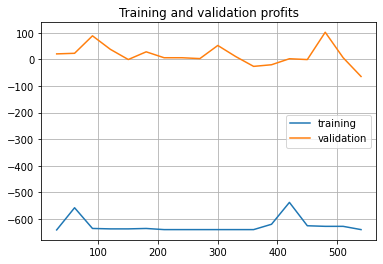

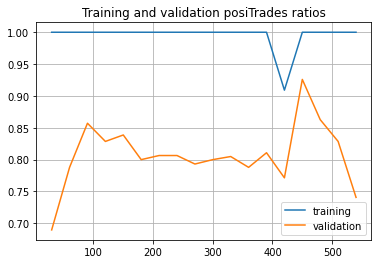

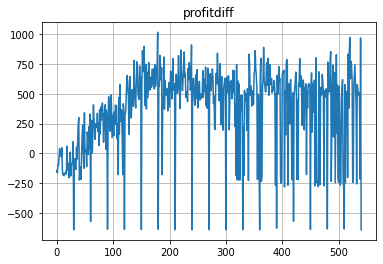

In [5]:

#maxEps = max([list(map(int, re.findall('\d+', file))) for file in files])[0]
episodes = [x[0] for x in files]
maxEps = max(episodes)
with open(f'./{load_dir}/e{maxEps}/history.json', 'r') as f:
    history = json.load(f)
with open(f'./{load_dir}/EXTRAhistory.json', 'r') as f:
    EXTRAhistory = json.load(f)

plt.figure()
plt.plot(episodes,history['training_profit'], label = "training")
plt.plot(episodes,history['validation_profit'], label = "validation")
plt.grid(True)
plt.title("Training and validation profits")
plt.legend()

plt.figure()
plt.plot(episodes,history['training_pratio'], label = "training")
plt.plot(episodes,history['validation_pratio'], label = "validation")
plt.grid(True)
plt.title("Training and validation posiTrades ratios")
plt.legend()

plt.figure()
plt.plot(EXTRAhistory['profitdiff_lst'])
plt.title("profitdiff")
plt.grid(True)

### Validation reruns

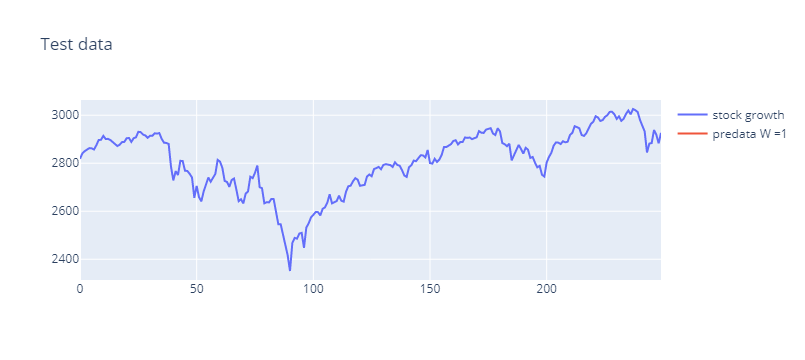

Naive buy & hold strategy on Test data has a portfolio growth of 0.083% per asset bought
For current budget of +$2701.58, this means 1 stocks bought results in a final portfolio growth of +$224.74 (i.e. final value =+$2926.32)


In [6]:
#dataType = "validationdata"
dataType = "testdata"
data_val, data_extra_val = UtilFuncs.get_data(dataType, data_extraWindow, SCRIPT_VERSION,  colab = using_colab)
l_val = len(data_val)-1
growth_buyhold_val = UtilFuncs.plot_data(agent, data_val, data_extra_val, data_extraWindow, window_size, training = False)

Succesfully loaded (actor:True|critic:True|buffer:False) models from folder runs/v17/content/v17_bigM and episode 30


  0%|          | 0/185 [00:00<?, ?it/s]

Final validation profit = -85.52 & extra cash = 50.0


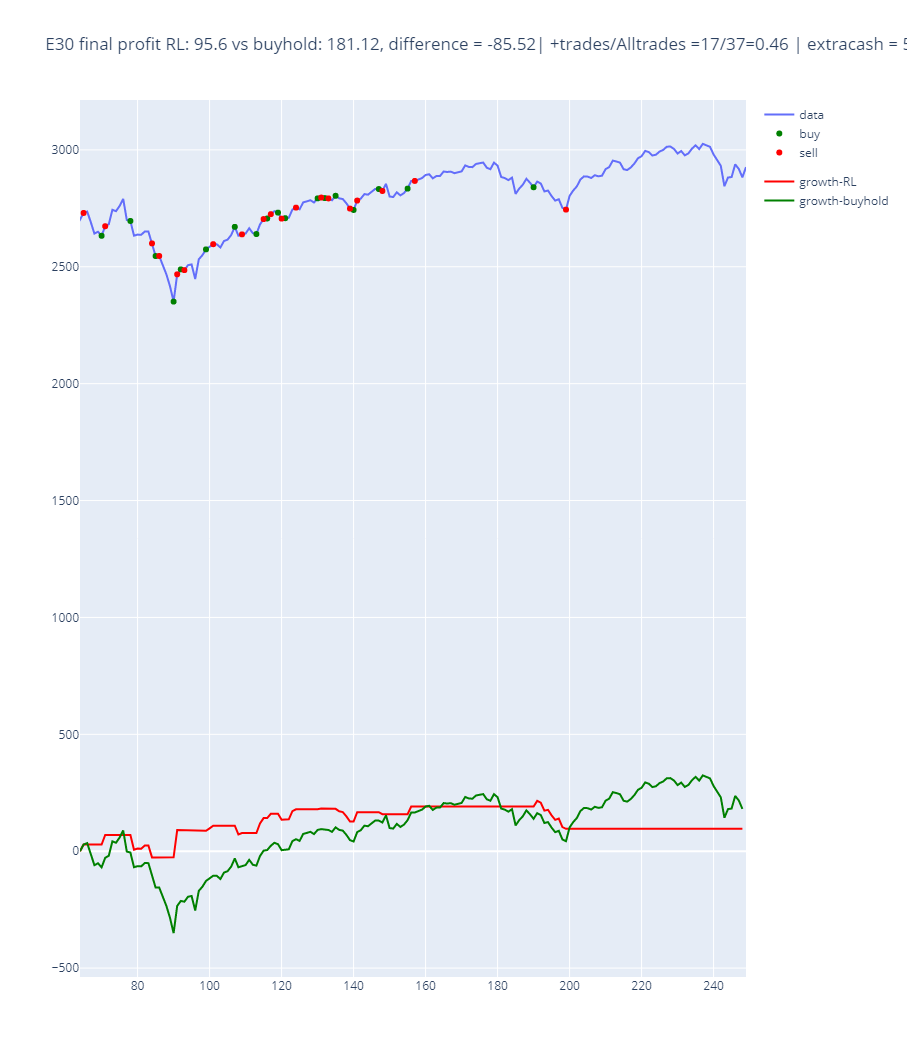

done with episode 30
E30-trades 17/37, imps=0
Succesfully loaded (actor:True|critic:True|buffer:False) models from folder runs/v17/content/v17_bigM and episode 60


  0%|          | 0/185 [00:00<?, ?it/s]

Final validation profit = -303.71 & extra cash = 188.95


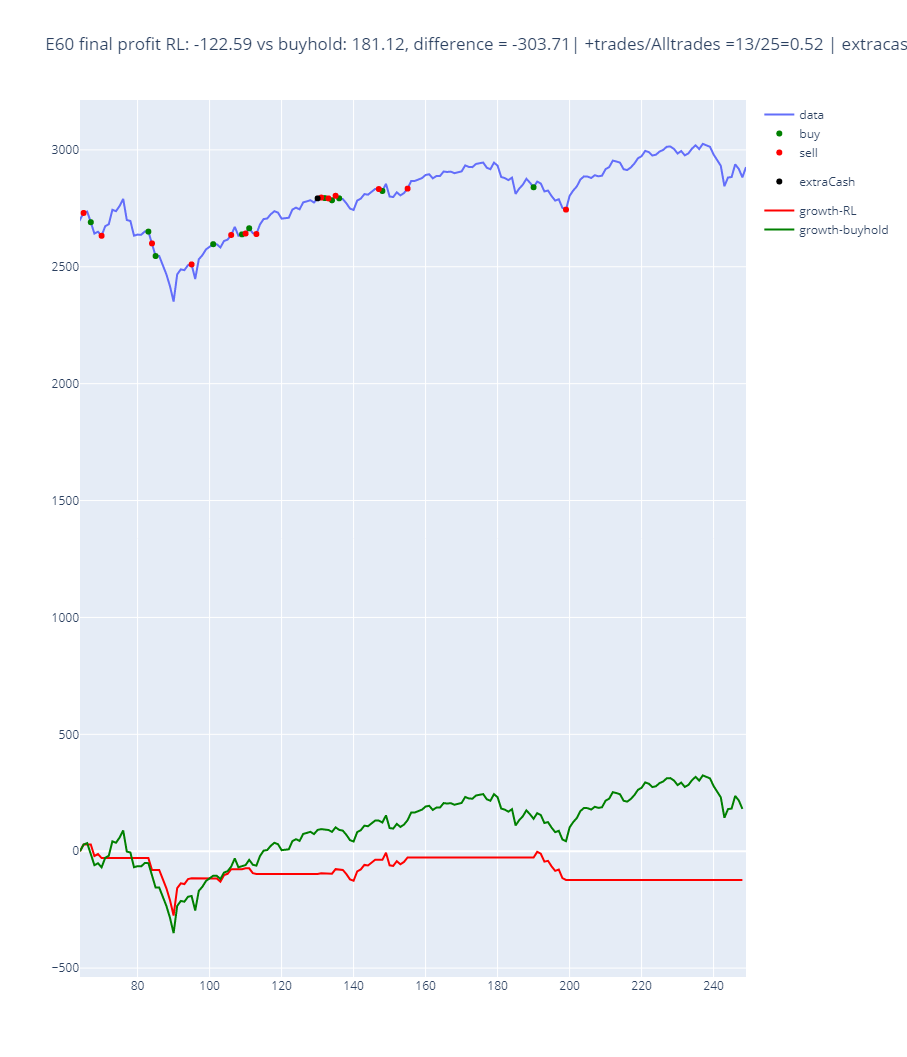

done with episode 60
E60-trades 13/25, imps=1
Succesfully loaded (actor:True|critic:True|buffer:False) models from folder runs/v17/content/v17_bigM and episode 90


  0%|          | 0/185 [00:00<?, ?it/s]

Final validation profit = -205.65 & extra cash = 145.82


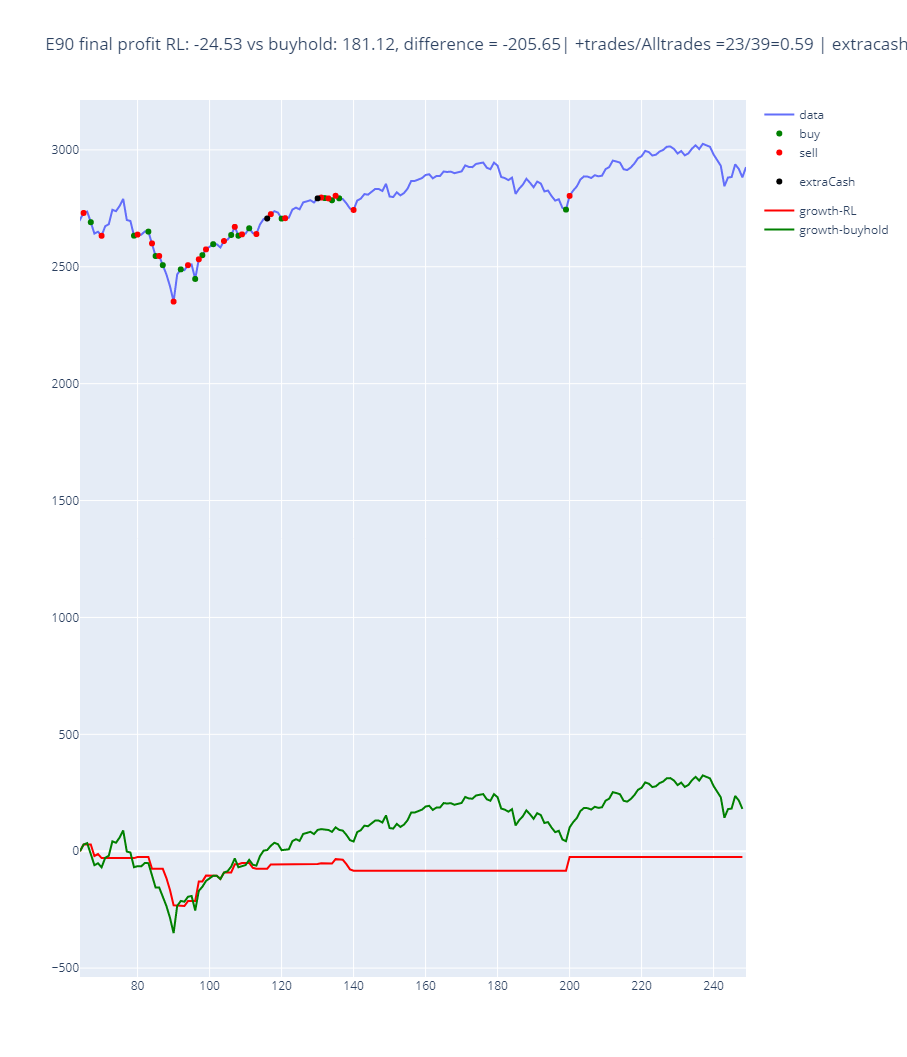

done with episode 90
E90-trades 23/39, imps=2
Succesfully loaded (actor:True|critic:True|buffer:False) models from folder runs/v17/content/v17_bigM and episode 120


  0%|          | 0/185 [00:00<?, ?it/s]

Final validation profit = -144.2 & extra cash = 140.46


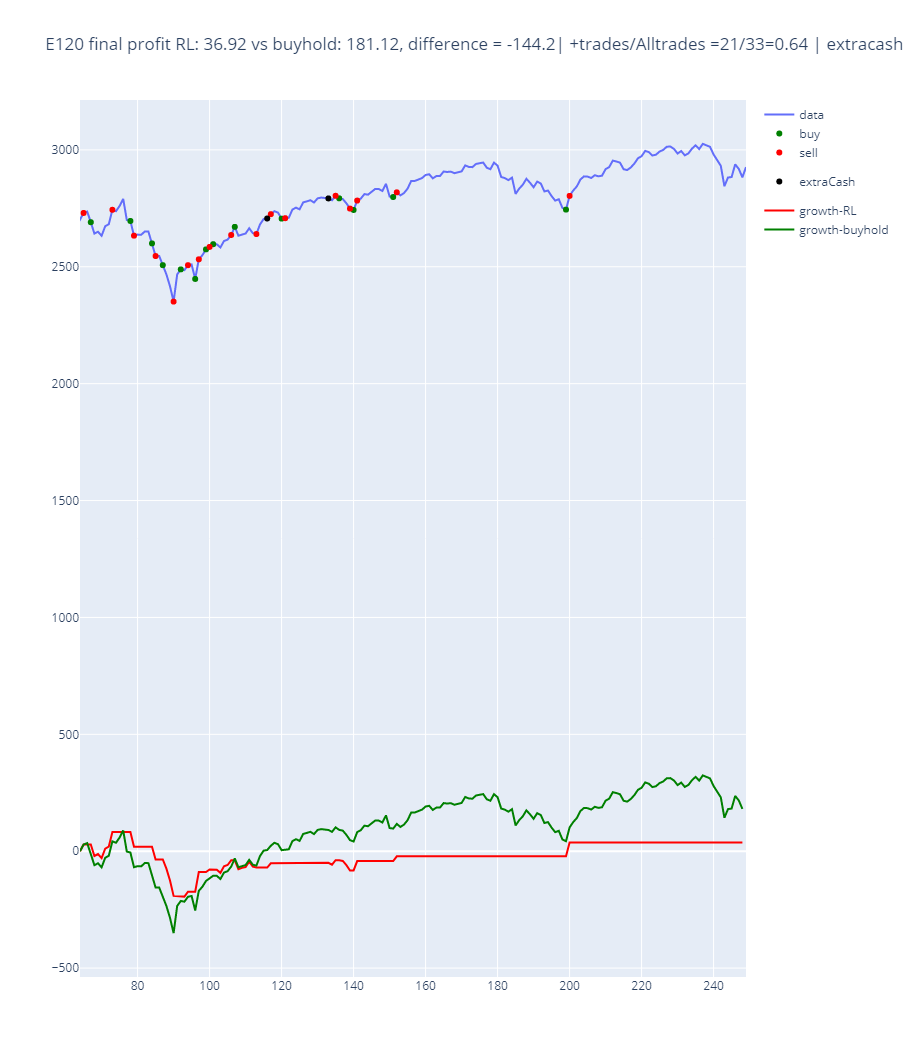

done with episode 120
E120-trades 21/33, imps=2
Succesfully loaded (actor:True|critic:True|buffer:False) models from folder runs/v17/content/v17_bigM and episode 150


  0%|          | 0/185 [00:00<?, ?it/s]

Final validation profit = -17.11 & extra cash = 50.0


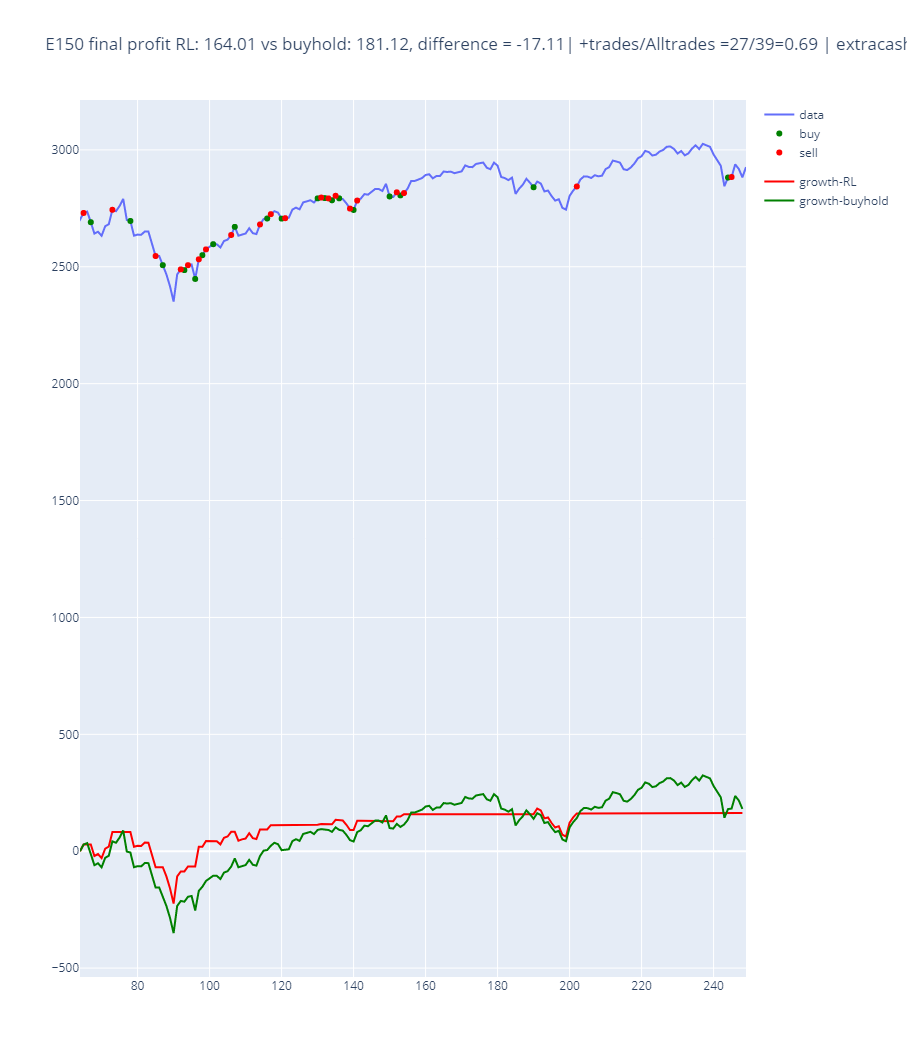

done with episode 150
E150-trades 27/39, imps=0
Succesfully loaded (actor:True|critic:True|buffer:False) models from folder runs/v17/content/v17_bigM and episode 180


  0%|          | 0/185 [00:00<?, ?it/s]

Final validation profit = -100.67 & extra cash = 166.68


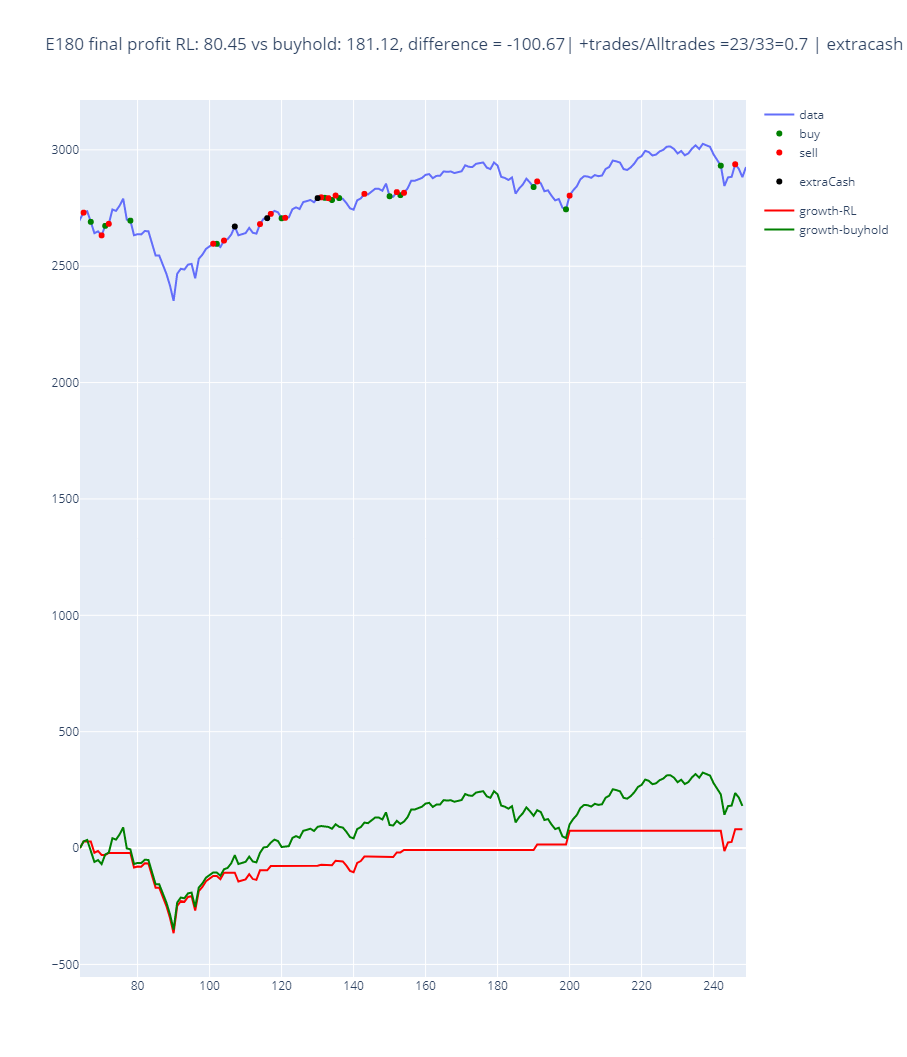

done with episode 180
E180-trades 23/33, imps=3
Succesfully loaded (actor:True|critic:True|buffer:False) models from folder runs/v17/content/v17_bigM and episode 210


  0%|          | 0/185 [00:00<?, ?it/s]

Final validation profit = -209.37 & extra cash = 210.65


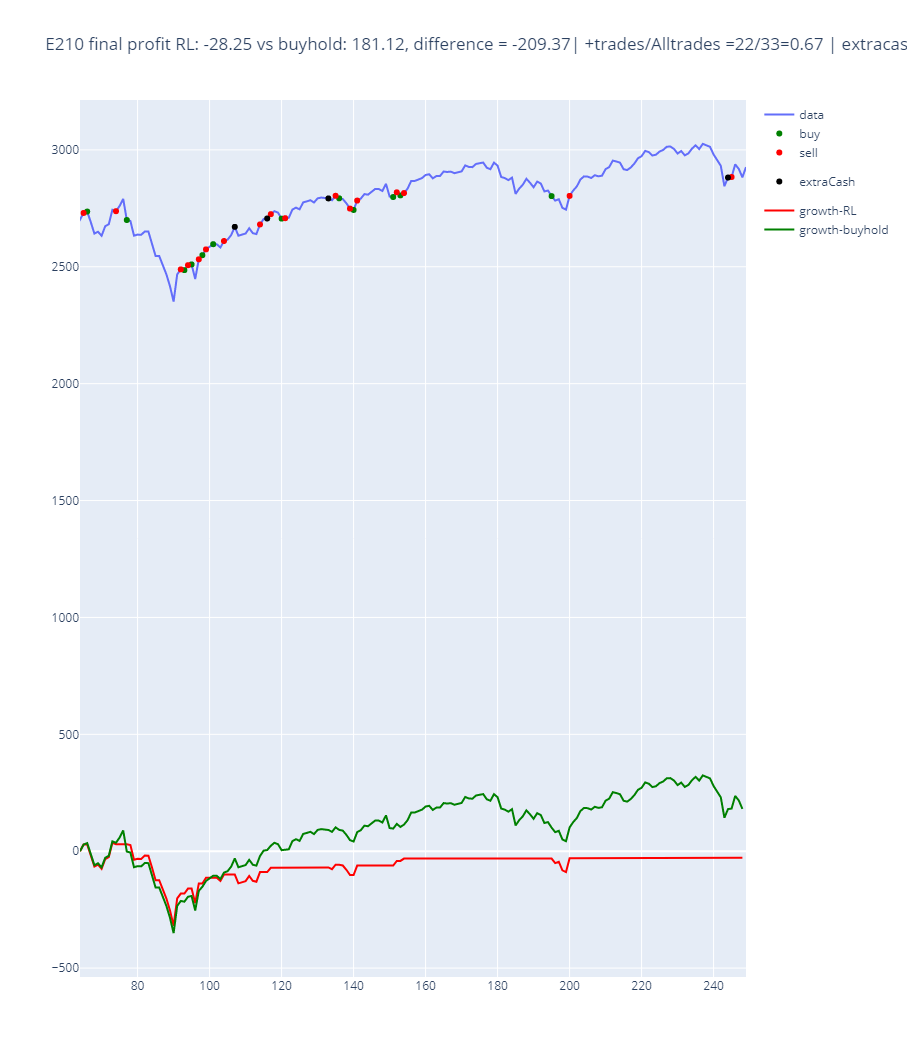

done with episode 210
E210-trades 22/33, imps=4
Succesfully loaded (actor:True|critic:True|buffer:False) models from folder runs/v17/content/v17_bigM and episode 240


  0%|          | 0/185 [00:00<?, ?it/s]

Final validation profit = 45.13 & extra cash = 50.0


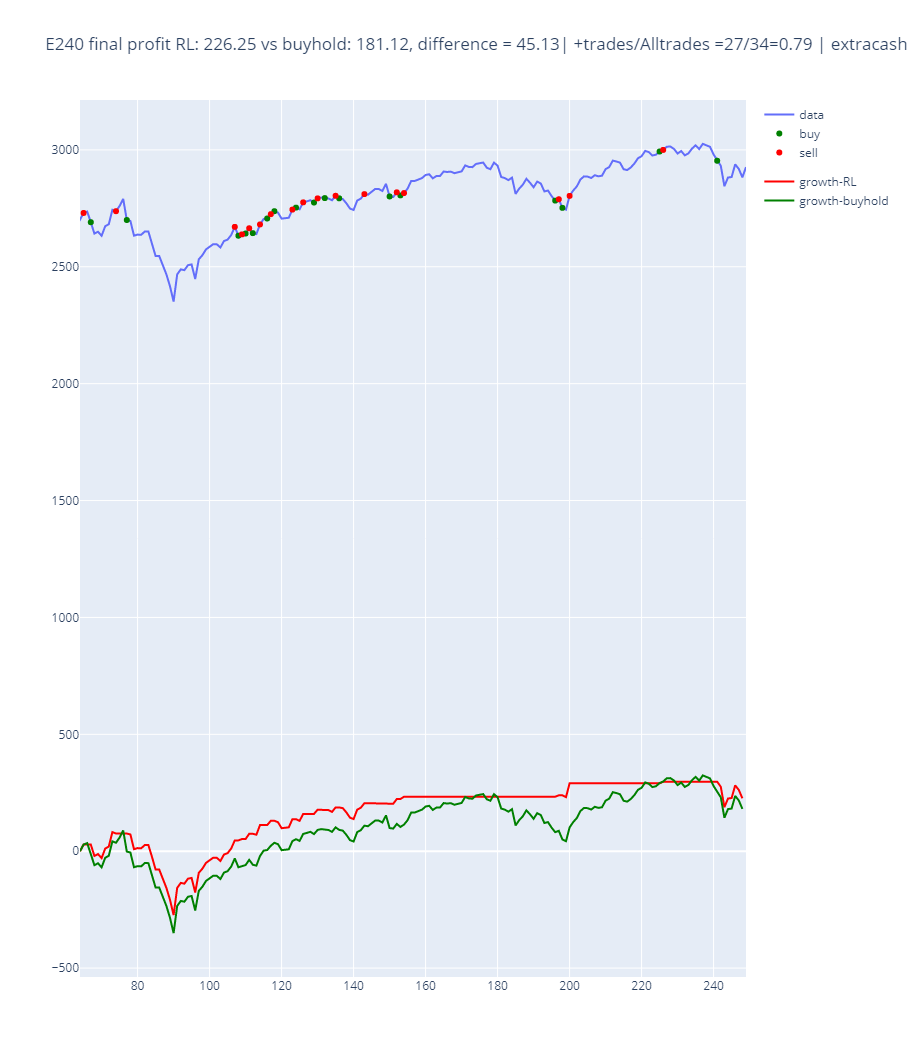

done with episode 240
E240-trades 27/34, imps=0
Succesfully loaded (actor:True|critic:True|buffer:False) models from folder runs/v17/content/v17_bigM and episode 270


  0%|          | 0/185 [00:00<?, ?it/s]

Final validation profit = 66.43 & extra cash = 50.0


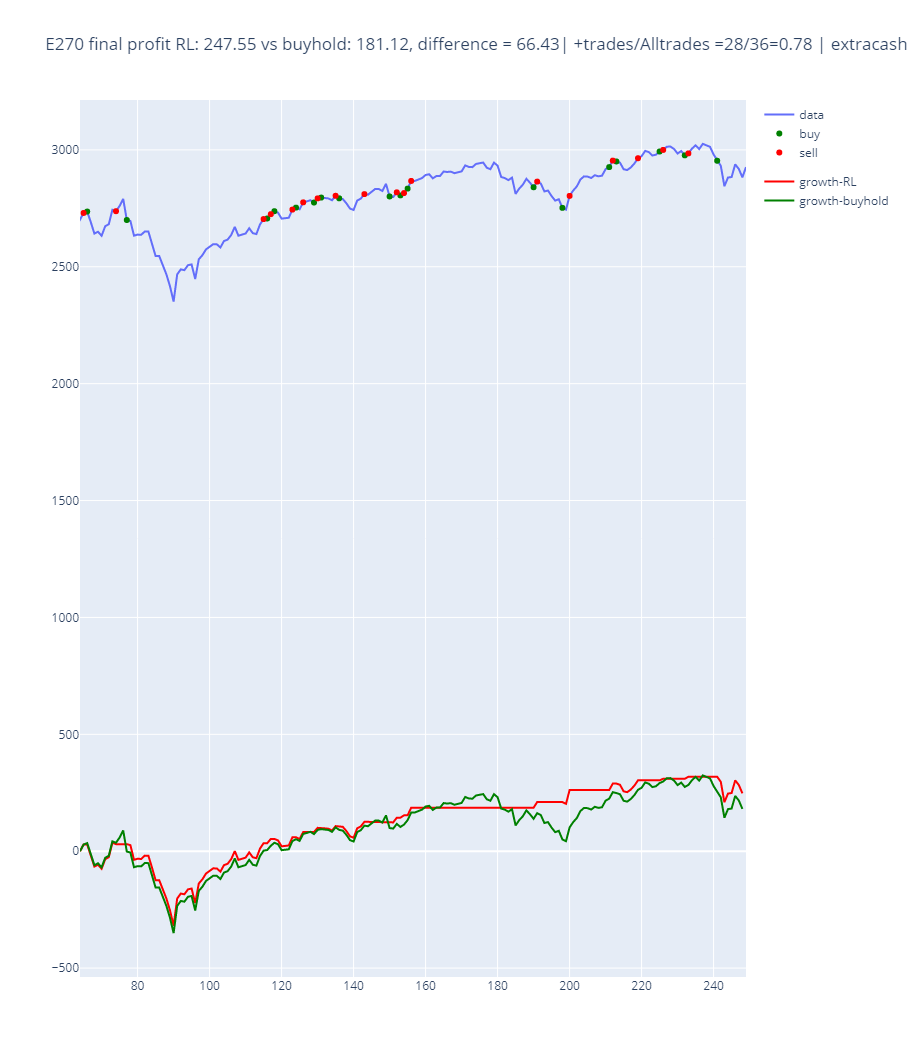

done with episode 270
E270-trades 28/36, imps=0
Succesfully loaded (actor:True|critic:True|buffer:False) models from folder runs/v17/content/v17_bigM and episode 300


  0%|          | 0/185 [00:00<?, ?it/s]

Final validation profit = 1.09 & extra cash = 50.0


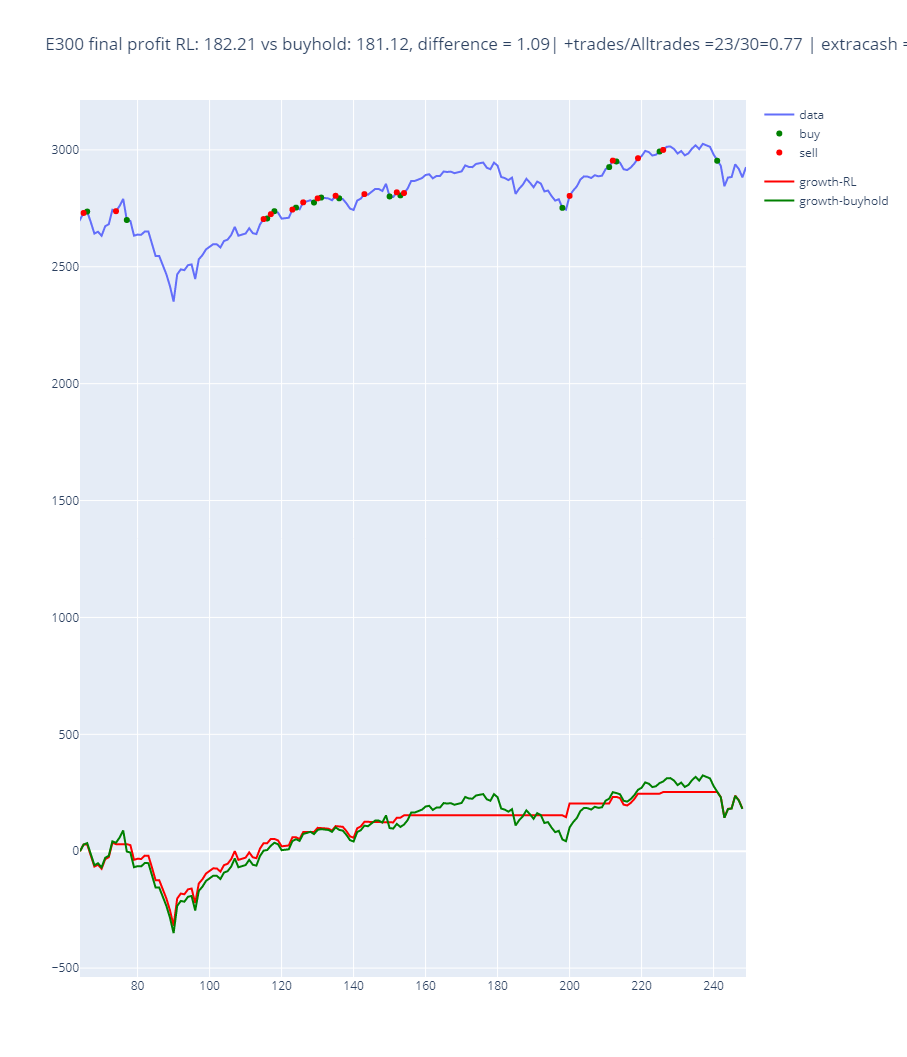

done with episode 300
E300-trades 23/30, imps=0
Succesfully loaded (actor:True|critic:True|buffer:False) models from folder runs/v17/content/v17_bigM and episode 330


  0%|          | 0/185 [00:00<?, ?it/s]

Final validation profit = -25.89 & extra cash = 50.0


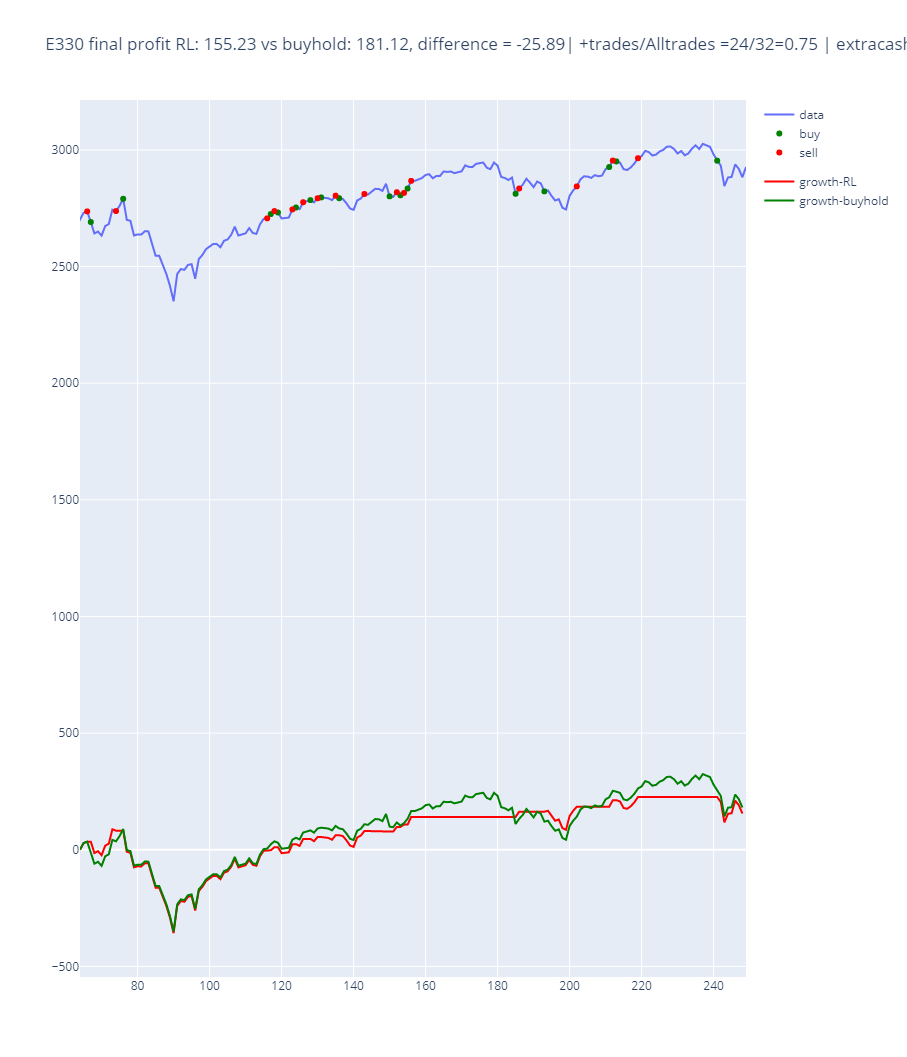

done with episode 330
E330-trades 24/32, imps=0
Succesfully loaded (actor:True|critic:True|buffer:False) models from folder runs/v17/content/v17_bigM and episode 360


  0%|          | 0/185 [00:00<?, ?it/s]

Final validation profit = 56.29 & extra cash = 50.0


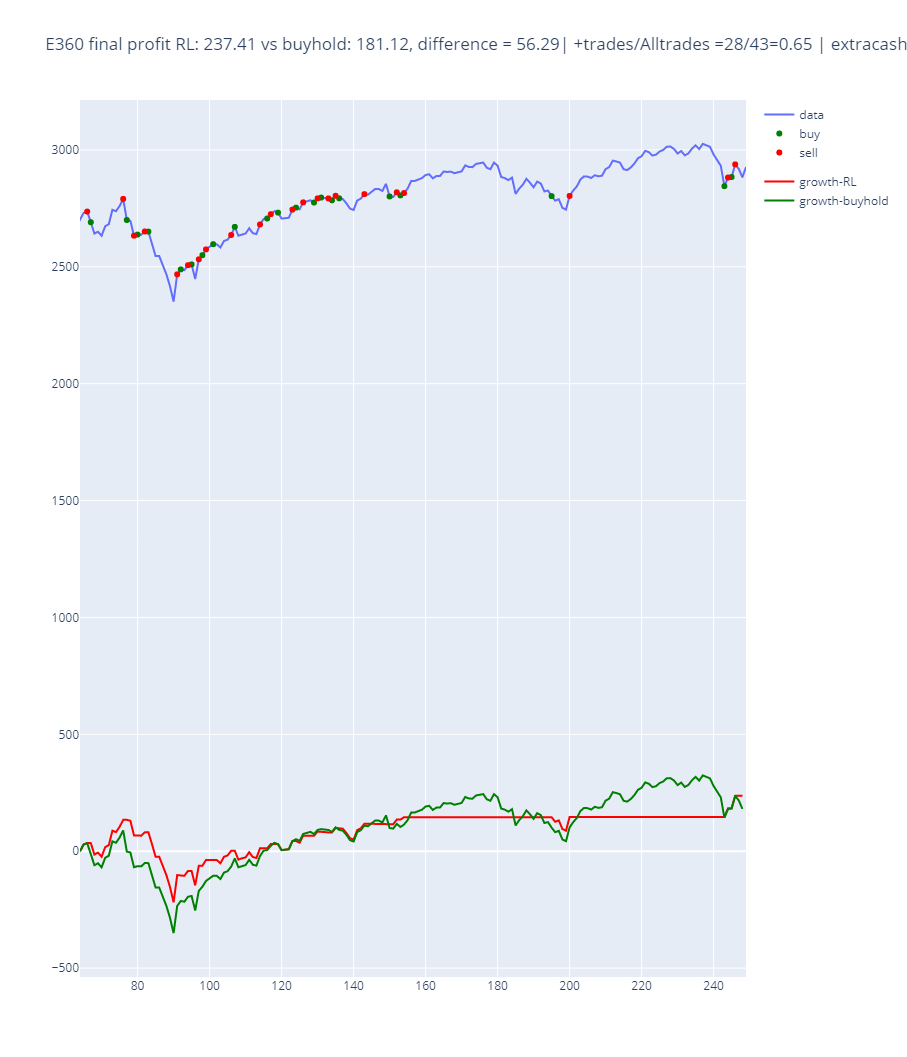

done with episode 360
E360-trades 28/43, imps=0
Succesfully loaded (actor:True|critic:True|buffer:False) models from folder runs/v17/content/v17_bigM and episode 390


  0%|          | 0/185 [00:00<?, ?it/s]

Final validation profit = 24.82 & extra cash = 50.0


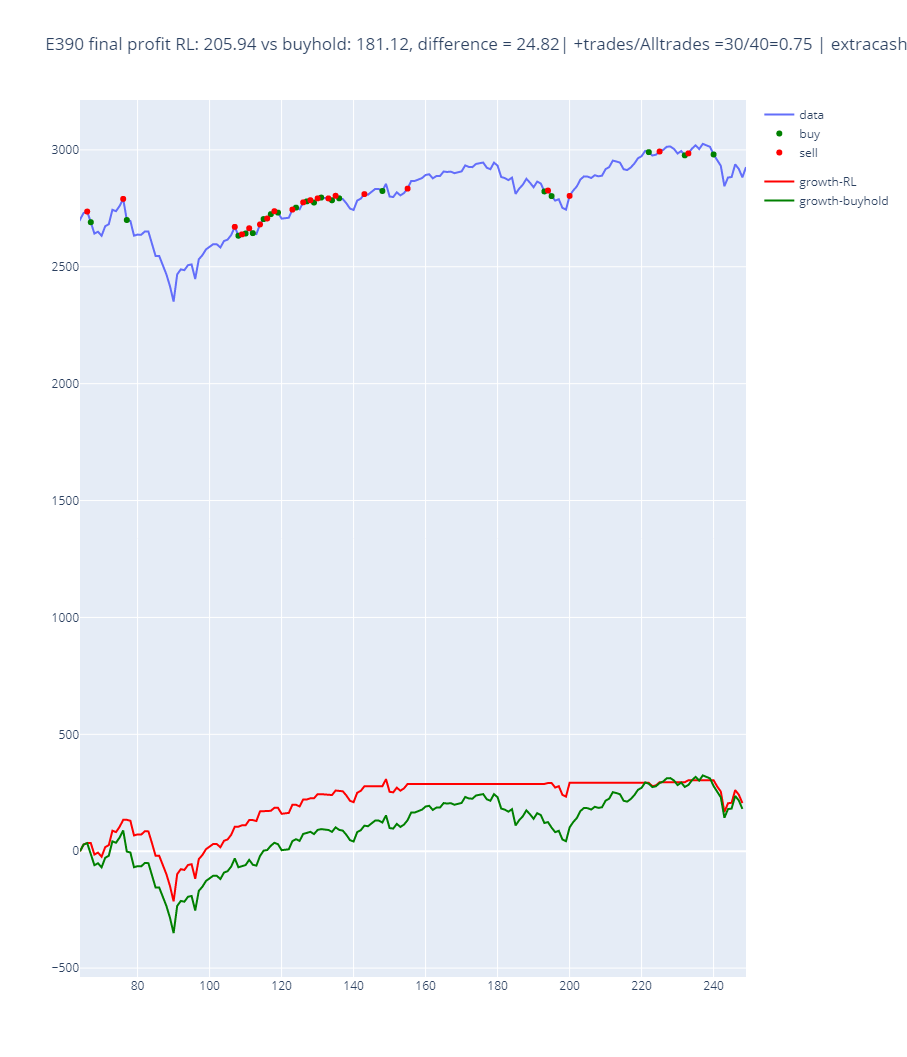

done with episode 390
E390-trades 30/40, imps=0
Succesfully loaded (actor:True|critic:True|buffer:False) models from folder runs/v17/content/v17_bigM and episode 420


  0%|          | 0/185 [00:00<?, ?it/s]

Final validation profit = 21.63 & extra cash = 50.0


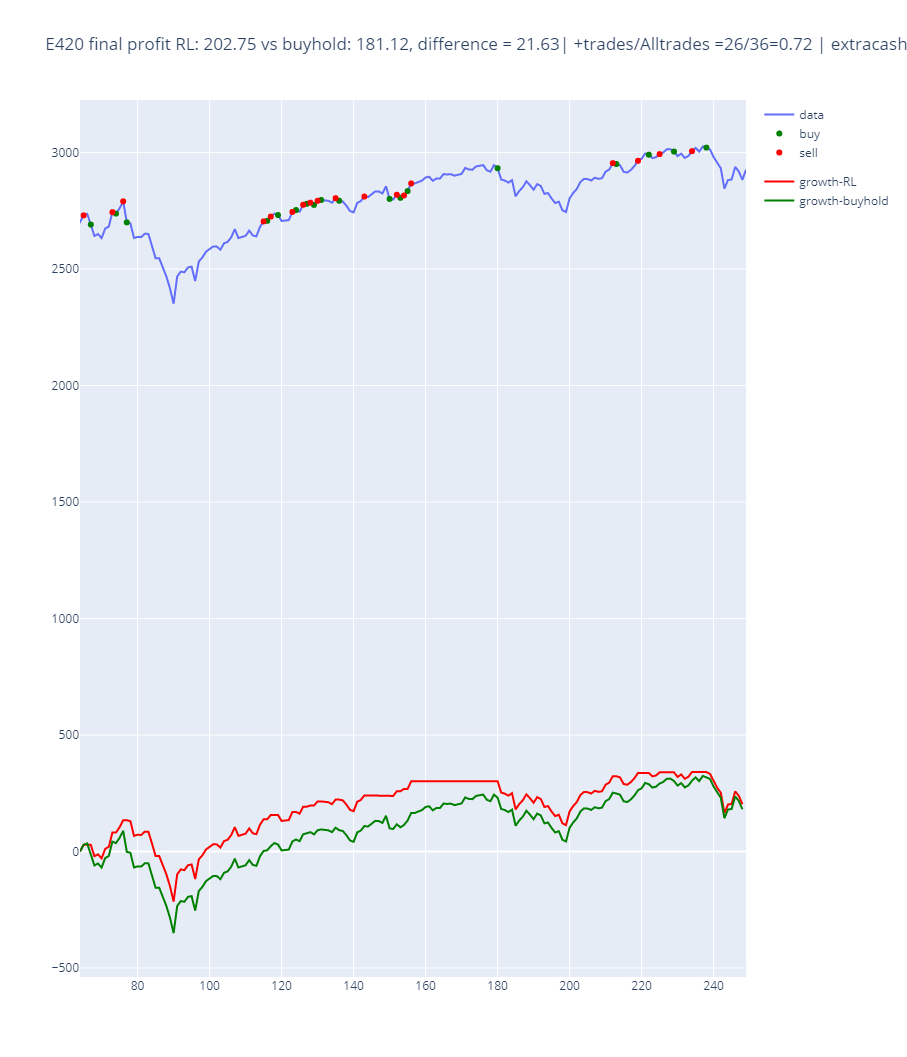

done with episode 420
E420-trades 26/36, imps=0
Succesfully loaded (actor:True|critic:True|buffer:False) models from folder runs/v17/content/v17_bigM and episode 450


  0%|          | 0/185 [00:00<?, ?it/s]

Final validation profit = -5.08 & extra cash = 50.0


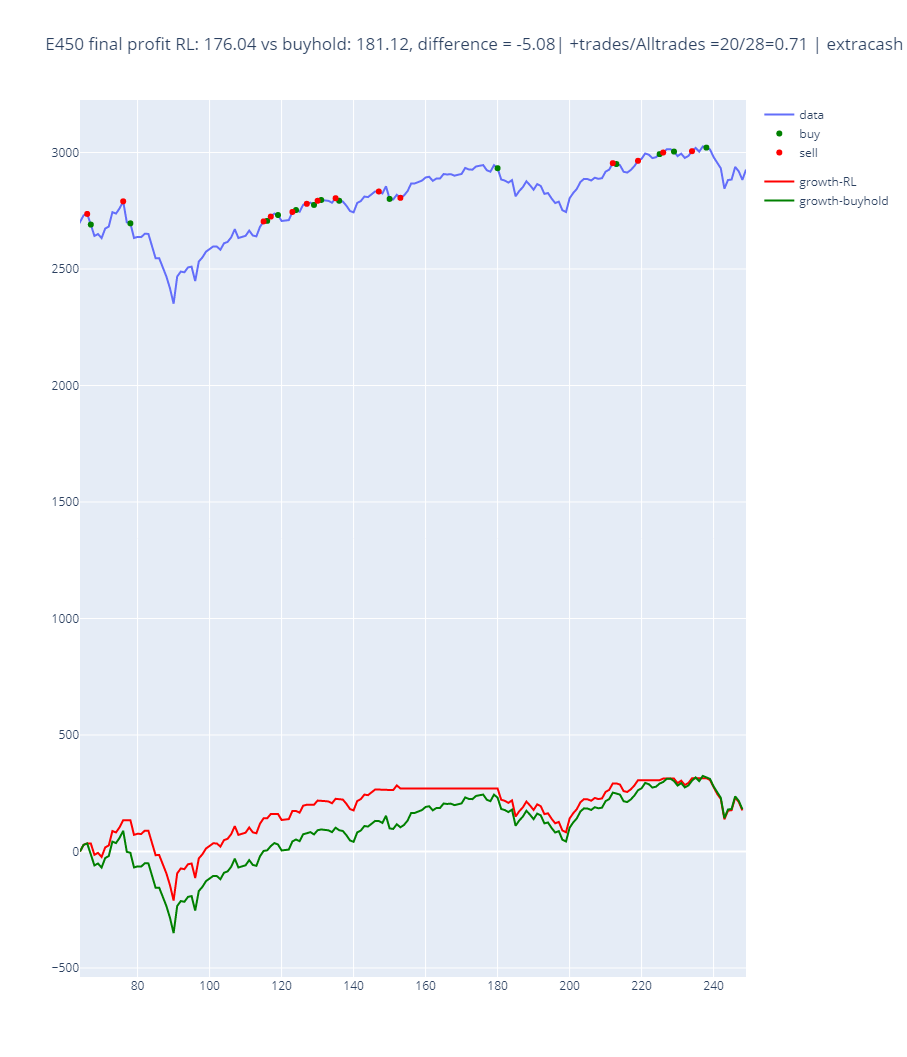

done with episode 450
E450-trades 20/28, imps=0
Succesfully loaded (actor:True|critic:True|buffer:False) models from folder runs/v17/content/v17_bigM and episode 480


  0%|          | 0/185 [00:00<?, ?it/s]

Final validation profit = 50.65 & extra cash = 50.0


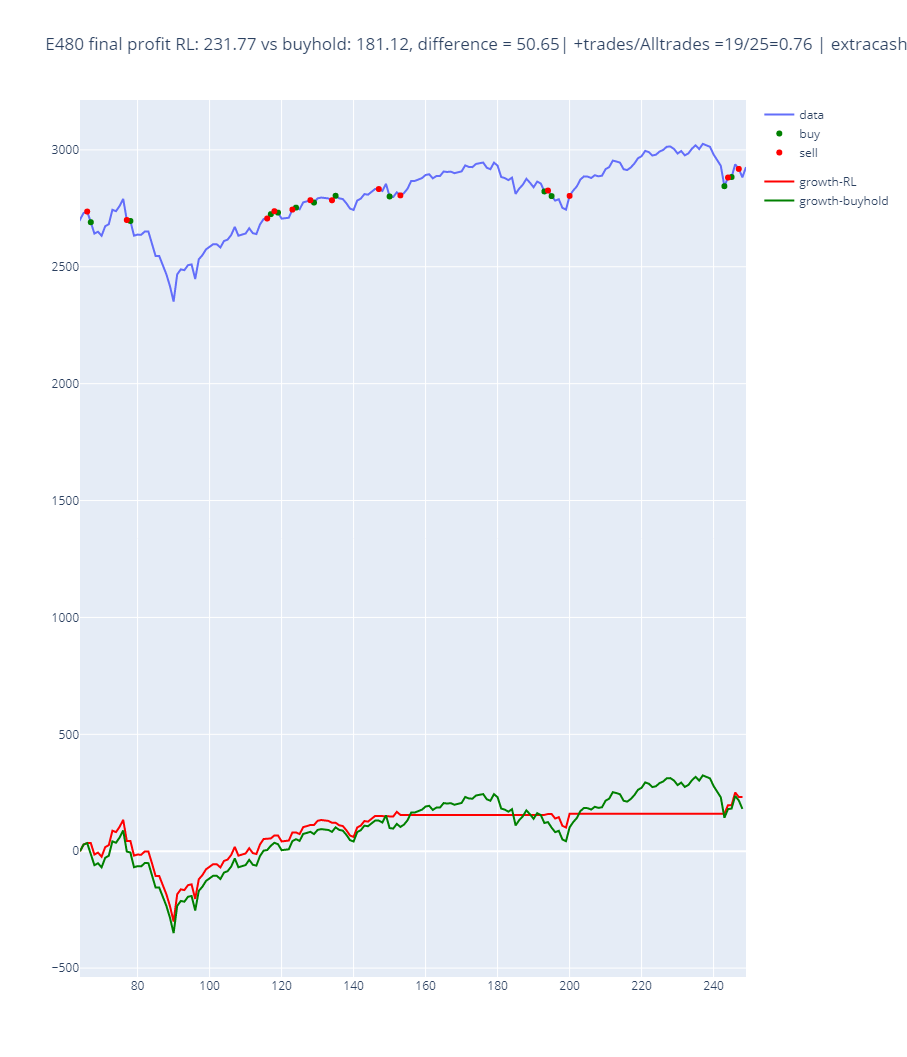

done with episode 480
E480-trades 19/25, imps=0
Succesfully loaded (actor:True|critic:True|buffer:False) models from folder runs/v17/content/v17_bigM and episode 510


  0%|          | 0/185 [00:00<?, ?it/s]

Final validation profit = 28.44 & extra cash = 50.0


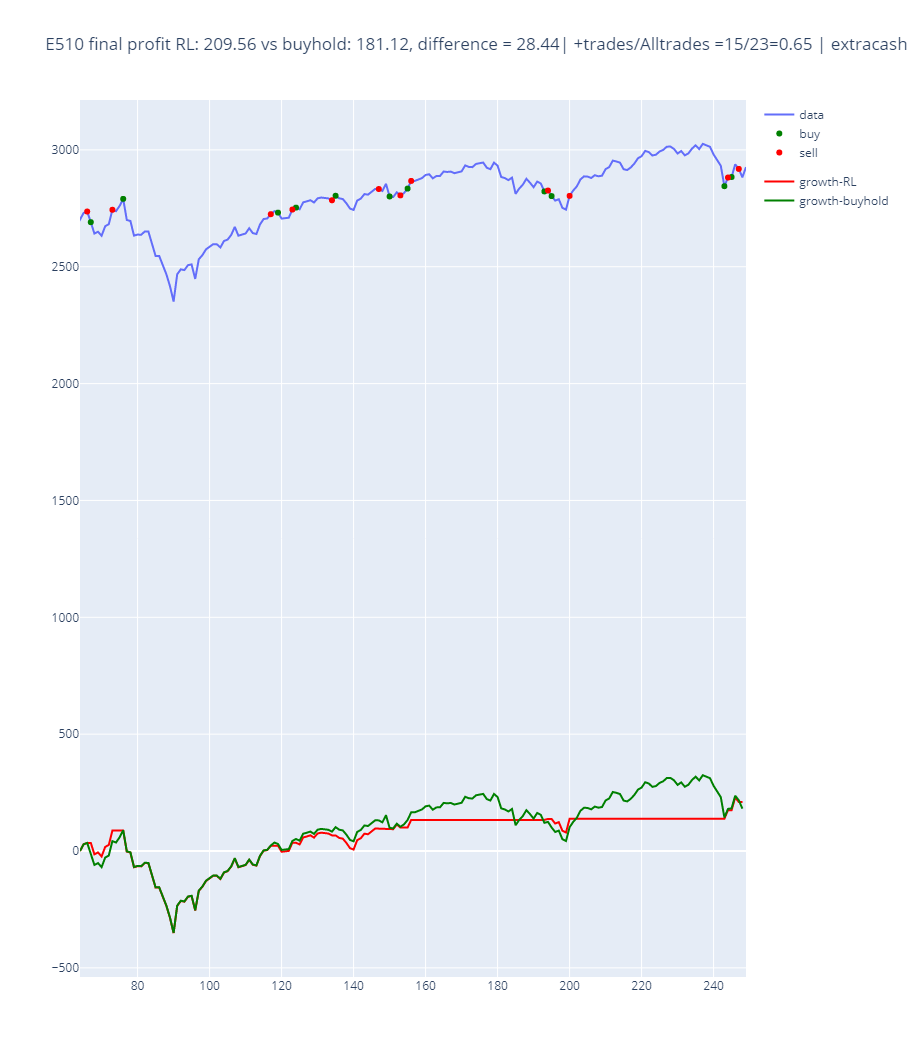

done with episode 510
E510-trades 15/23, imps=0
Succesfully loaded (actor:True|critic:True|buffer:False) models from folder runs/v17/content/v17_bigM and episode 540


  0%|          | 0/185 [00:00<?, ?it/s]

Final validation profit = -22.04 & extra cash = 50.0


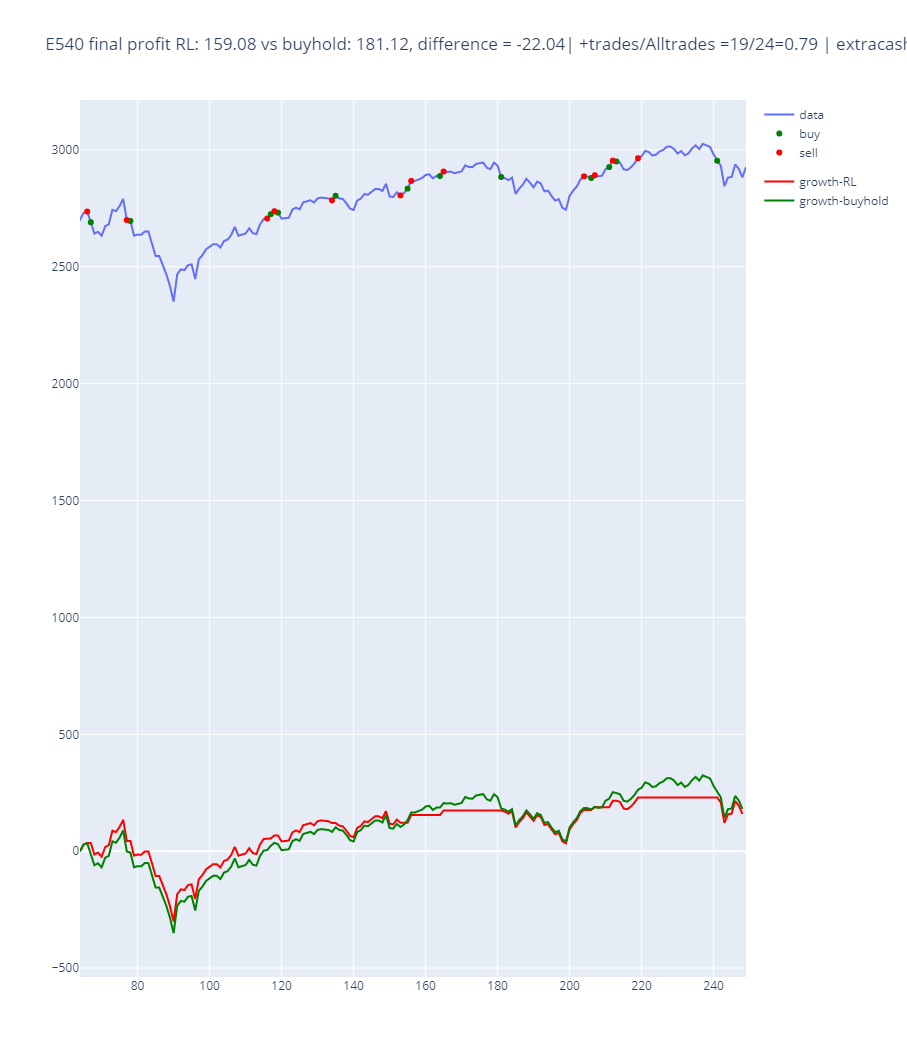

done with episode 540
E540-trades 19/24, imps=0


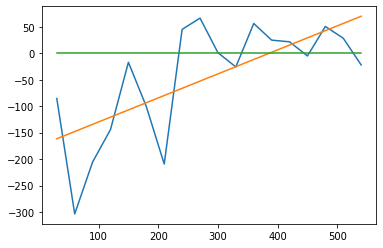

In [7]:
history = {}
history["validation"] = []
# ================ VALIDATION LOOP ===============================
'''
RESET THE SLICING TO [2:] NOT [3:]
'''
episodes = [x[0] for x in files]

EXTRACASH = 50
HORIZON = 0
use_local = True
show_figs = True
no_extracash = False

use_terminateFunc = True
terminateFunc_on = False
#episodes = episodes[-1:]
stats_val.reset_all(agent.n_budget*data_val[window_size], growth_buyhold_val)
for e in episodes:
    agent.load_models(load_dir,e)
    stats_val.reset_episode()
    agent.is_eval = True
    agent.reset(data_val[window_size])
    
    agent.balance += EXTRACASH
    stats_val.extraCash += EXTRACASH
    
    
    for t in trange(window_size,l_val):
        utils_state = [l_val, stats_val.n_holds,stats_val.n_trades, agent.trade_cost]
        state = UtilFuncs.get_state(agent, data_val, t, window_size + 1, utils_state)
        utils_act = []
        action, action_prob = agent.act(state, utils_act, use_local = use_local)

        flags = [use_terminateFunc, terminateFunc_on]
        utils_hdlAct = [action_prob]
        action, profit,  impossible, terminate, term_msg = UtilFuncs.handle_action(agent, stats_val, action, data_val, 
                                                                                   t, flags, utils_hdlAct, training = no_extracash)
        utils_saveIter = [profit, 0., 0., action, t-window_size]
        stats_val.collect_iteration(agent,utils_saveIter)
        
        #if action == 2 and agent.balance < np.min(data_val[(t+1):(t+HORIZON)]):
        '''
        if not bool(agent.inventory) and agent.balance < np.min(data_val[(t+1):(t+HORIZON)]): 
            #print(t)
            #print("yes")
            n_mins = sum(data_val[(t+1):] < agent.balance) # amount of times there is an opportunity to return to market
            if n_mins <= 5:
                stats_val.agent.EXTRACASH += data_val[t+1] - agent.balance # extra cash required for purchase
                stats_val.xtr_ind.append(t+1)
                agent.reset(data_val[t+1]) # reset the portfolio
        '''
        '''
        if not bool(agent.inventory) and agent.balance < data_val[t] and np.argmax(action_prob) == 1:
        #if not bool(agent.inventory) and np.argmax(action_prob) == 1 and all(agent.balance < data_val[(t):(t+HORIZON)]):
            #agent.EXTRACASHreq = data_val[t+1] - agent.balance
            stats_val.extraCash += data_val[t] - agent.balance - agent.trade_cost # extra cash required for purchase
            stats_val.xtr_ind.append(t)
            agent.reset(data_val[t]) # reset the portfolio, as if we did buy it
            #agent.balance += agent.EXTRACASHreq
        '''
        #if t < 490 and t > 475:
        #    print("a={0}/b={1}/t={2}".format(action, agent.balance, t))

    stats_val.collect_episode(agent, e, [])
    print("Final validation profit = {0} & extra cash = {1}".format(round(stats_val.compete[-1],2), 
                                                                    round(stats_val.extraCash,2)))
    utils_fig = [l_val, window_size]
    stats_val.plot_figure(data_val, e, utils_fig, show_figs = show_figs)
    history["validation"].append(stats_val.compete[-1])
    # ============= END VALIDATION LOOP =============================
    print("done with episode {}".format(e))
    print("E{0}-trades {1}/{2}, imps={3}".format(e, stats_val.n_posiProfits,stats_val.n_trades, 
                                                 stats_val.n_impossible))
with open(f'./{load_dir}/results/validation_redone.json', 'w') as fp:
    json.dump(history, fp)
    
    
# PLOTTING
x = np.arange(0,len(episodes))
y= np.array(history["validation"])
coef = np.polyfit(x,y,1)
plt.plot(np.array(episodes),np.array(history["validation"]))
plt.plot(np.array(episodes),np.arange(len(episodes))*coef[0]+coef[1])
plt.plot(np.array(episodes),np.zeros((len(episodes))))

In [ ]:
#episodes = episodes[-10:]
x = np.arange(0,len(episodes))
y= np.array(history["validation"])
coef = np.polyfit(x,y,1)
plt.plot(np.array(episodes),np.array(history["validation"]))
plt.plot(np.array(episodes),np.arange(len(episodes))*coef[0]+coef[1])
plt.plot(np.array(episodes),np.zeros((len(episodes))))

# ============== EXTRA - SKIP =============

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.array(episodes),np.array(history["validation"][82:]))

In [ ]:
stats_val.reset_episode()
agent.is_eval = True
agent.reset(data_val[window_size])
for t in trange(window_size,l_val):
    utils_state = [l_val, stats_val.n_holds,stats_val.n_trades]
    state = UtilFuncs.get_state(agent, data_val, t, window_size + 1, utils_state)
    utils_act = [prob,data_val[t]]
    action, action_prob = agent.act(state, utils_act)

    flags = [use_terminateFunc, terminateFunc_on]
    action, profit,  impossible, terminate, term_msg = UtilFuncs.handle_action(agent, stats_val, action, data_val, 
                                                                               t, flags, training = False)
    utils_saveIter = [profit, 0., 0., action]
    stats_val.collect_iteration(agent,utils_saveIter)

stats_val.collect_episode(agent, e, [])
utils_fig = [l_val, window_size]
stats_val.plot_figure(data_val, e, utils_fig, show_figs = show_figs)

In [ ]:

stats_val.collect_episode(agent, e, [])
utils_fig = [l_val, window_size]
stats_val.plot_figure(data_val, e, utils_fig, show_figs = show_figs)